In [1]:
import nest
import nest.raster_plot
import numpy as np
from sklearn.decomposition import PCA

from utils.inputs import generate_piecewise_constant_signal
# from utils.extractors import filter_spikes, filter_spikes_parallel
from utils.capacity import compute_capacity

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: Oct 17 2024 16:05:40

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In this final example, we will assess the network's memory capacity.

# Global settings

In [2]:
seed = 10
np.random.seed(seed)

In [3]:
dt = 0.1  # simulation resolution
num_threads = 16

# Initialize NEST
nest.ResetKernel()
nest.SetKernelStatus({
    'rng_seed': seed,
    'resolution': dt,
    'local_num_threads': num_threads
})


Oct 24 14:26:30 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.


---
# Balanced Random Network

For this example, we will use a standard Brunel balanced random network (see NEST tutorials). However, you are encouraged to explore different neuron and synapse models and/or more complex connectivity schemes.

In [4]:
# network parameters
gamma = 0.25               # relative number of inhibitory connections
NE = 100                  # number of excitatory neurons (10.000 in [1])
NI = int(gamma * NE)       # number of inhibitory neurons
CE = 10                  # indegree from excitatory neurons
CI = int(gamma * CE)       # indegree from inhibitory neurons

In [5]:
# synapse parameters
w = 0.1                    # excitatory synaptic weight (mV)
g = 5.                     # relative inhibitory to excitatory synaptic weight
d = 1.5                    # synaptic transmission delay (ms)

In [6]:
# neuron paramters
V_th = 20.                 # spike threshold (mV)
tau_m = 20.                # membrane time constant (ms)
neuron_params = {
    'C_m': 1.0,            # membrane capacity (pF)
    'E_L': 0.,             # resting membrane potential (mV)
    'I_e': 0.,             # external input current (pA)
    'V_m': 0.,             # membrane potential (mV)
    'V_reset': 10.,        # reset membrane potential after a spike (mV)
    'V_th': V_th,          #
    't_ref': 2.0,          # refractory period (ms)
    'tau_m': tau_m,        #
}

### Create and connect populations

In [7]:
# set default parameters for neurons and create neurons
nest.SetDefaults('iaf_psc_delta', neuron_params)
neurons_e = nest.Create('iaf_psc_delta', NE)
neurons_i = nest.Create('iaf_psc_delta', NI)

# create excitatory connections
# synapse specification
syn_exc = {'delay': d, 'weight': w}
# connection specification
conn_exc = {'rule': 'fixed_indegree', 'indegree': CE}
# connect stuff
nest.Connect(neurons_e, neurons_e, conn_exc, syn_exc)
nest.Connect(neurons_e, neurons_i, conn_exc, syn_exc)

# create inhibitory connections
# synapse specification
syn_inh = {'delay': d, 'weight': - g * w}
# connection specification
conn_inh = {'rule': 'fixed_indegree', 'indegree': CI}
# connect stuff
nest.Connect(neurons_i, neurons_e, conn_inh, syn_inh)
nest.Connect(neurons_i, neurons_i, conn_inh, syn_inh)

### Create and connect external inputs
We are going to drive the circuit with a patterned stimulus signal.

In [8]:
# external input (stimulus)
input_dt = 1.          # [ms] 
step_duration = 50.    # [ms]
scale = 10000.         # input scaling factor [Hz]
num_steps = 100        # number of unique input values

sig, times, inp_times, inp_amplitudes = generate_piecewise_constant_signal(seed=seed, num_steps=num_steps, 
                                                                           step_duration=step_duration, 
                                                                           resolution=input_dt, scale=scale)

Text(0.5, 1.0, '$u(t)$')

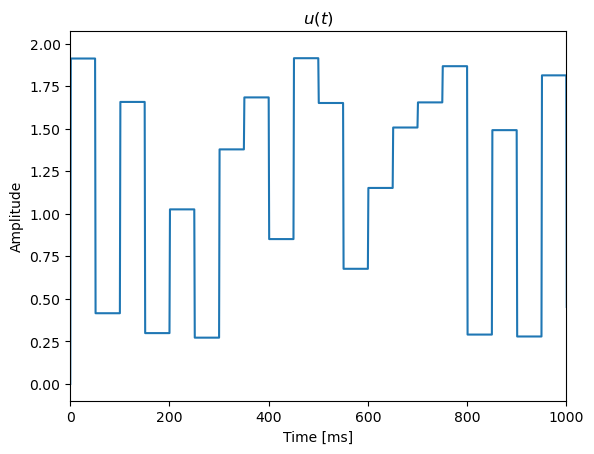

In [9]:
# visualize example input stimulus
fig, ax = plt.subplots()
ax.plot(times, sig)
ax.set_xlim([0, 1000])
ax.set_xlabel(r'Time [ms]')
ax.set_ylabel(r'Amplitude')
ax.set_title(r'$u(t)$')

In [10]:
# create inhomogeneous poisson generator (time-dependent input signal)
stim_pgen = nest.Create('inhomogeneous_poisson_generator', 1)
stim_pgen.set({'rate_times': inp_times, 'rate_values': inp_amplitudes})

In [11]:
# connect poisson generator using the excitatory connection weight
nest.Connect(stim_pgen, neurons_e, syn_spec=syn_exc)
nest.Connect(stim_pgen, neurons_i, syn_spec=syn_exc)

### Create and connect recording devices
Note: we will restrict the analysis to the activity of the excitatory neurons. If you run into memory or time constraints, you can also downsample and record from a smaller subset of neurons. To simplify the analysis, we will record the membrane potential.

In [12]:
vm = nest.Create('multimeter', 1, {'record_from': ['V_m'], 'interval': input_dt})
nest.Connect(vm, neurons_e)

## Simulate

In [13]:
nest.Simulate(num_steps*step_duration)


Oct 24 14:26:31 NodeManager::prepare_nodes [Info]: 
    Preparing 157 nodes for simulation.

Oct 24 14:26:31 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 157
    Simulation time (ms): 5000
    Number of OpenMP threads: 16
    Not using MPI

Oct 24 14:26:32 SimulationManager::run [Info]: 
    Simulation finished.


In [14]:
# to acquire the last time step in the multimeter
nest.Simulate(dt)


Oct 24 14:26:32 NodeManager::prepare_nodes [Info]: 
    Preparing 157 nodes for simulation.

Oct 24 14:26:32 SimulationManager::run [Warning]: 
    The requested simulation time is not an integer multiple of the minimal 
    delay in the network. This may result in inconsistent results under the 
    following conditions: (i) A network contains more than one source of 
    randomness, e.g., two different poisson_generators, and (ii) Simulate is 
    called repeatedly with simulation times that are not multiples of the 
    minimal delay.

Oct 24 14:26:32 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 157
    Simulation time (ms): 0.1
    Number of OpenMP threads: 16
    Not using MPI

Oct 24 14:26:32 SimulationManager::run [Info]: 
    Simulation finished.


## Post-process data
Extract state matrix using the membrane potentials as state variables

In [15]:
activity = vm.events
indices = np.sort(np.unique(activity['senders']))
states = np.zeros((NE, int(num_steps*step_duration)))
for idx, i in enumerate(indices):
    states[idx, :] = activity['V_m'][np.where(activity['senders']==i)[0]]

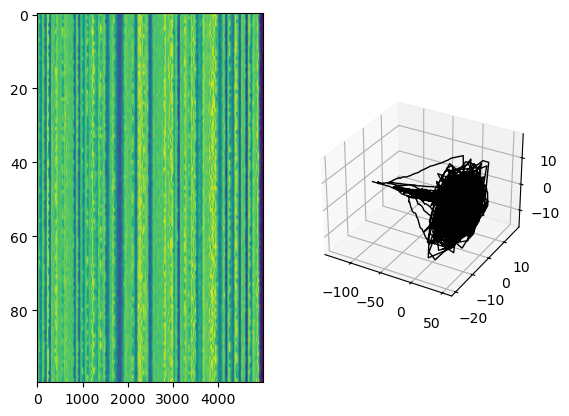

In [16]:
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.imshow(states, aspect='auto')
ax2 = fig.add_subplot(122, projection='3d')
pca_fit = PCA(n_components=np.shape(states)[0])
X = pca_fit.fit_transform(states.T)
ax2.plot(X[:, 0], X[:, 1], X[:, 2], color='k', lw=1)

## Decoding

In [17]:
# exclude initial values at time 0.
sig = sig[1:]
times = times[1:]

In [18]:
# computes memory capacity at stimulus offset
estimate, capacity, error = compute_capacity(states, sig)
print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))


Elapsed time for capacity computation: 0.2088487148284912
Capacity=0.4281709640297973, MSE=0.16863088987790897


## Memory capacity
Finally, we calculate capacity at increasing time lags (delays) after stimulus offset:

In [19]:
max_lag = 100.   # [ms] in this example
step_lag = 10.   # [ms] evaluate in discrete time points (alternatively set == 1. for higher resolution)
time_lags = np.arange(input_dt, max_lag, step_lag)
indices = [np.where(idx==times)[0][0] for idx in time_lags]

memory_capacity = []

for idx, lag in zip(indices, time_lags):
    
    # shift the target signal
    if idx > 0:
        shifted_signal = sig[:-idx]
    else:
        shifted_signal = sig
    
    # shift the population states
    st = states[:, idx:]
    
    # compute capacity
    estimate, capacity, error = compute_capacity(st, shifted_signal)
    
    print("Lag = {0} ms".format(str(lag)))
    print("Capacity={0}, MSE={1}".format(str(capacity), str(error)))
    
    memory_capacity.append(capacity)


Elapsed time for capacity computation: 0.27826380729675293
Lag = 1.0 ms
Capacity=0.4281709640297973, MSE=0.16863088987790897

Elapsed time for capacity computation: 0.12522578239440918
Lag = 11.0 ms
Capacity=0.47789445313121154, MSE=0.15914247549517138

Elapsed time for capacity computation: 0.09148907661437988
Lag = 21.0 ms
Capacity=0.3976120727642689, MSE=0.1785749037723744

Elapsed time for capacity computation: 0.09965109825134277
Lag = 31.0 ms
Capacity=0.2886105147257171, MSE=0.20634393478002058

Elapsed time for capacity computation: 0.06114935874938965
Lag = 41.0 ms
Capacity=0.17296721476309898, MSE=0.24299765212421198

Elapsed time for capacity computation: 0.06723380088806152
Lag = 51.0 ms
Capacity=0.08619424497240799, MSE=0.2813804644242906

Elapsed time for capacity computation: 0.07097649574279785
Lag = 61.0 ms
Capacity=0.024637745187159825, MSE=0.31805106620478657

Elapsed time for capacity computation: 0.0831298828125
Lag = 71.0 ms
Capacity=0.01996078824242436, MSE=0.321

Total capacity: 19.71972086807919 ms


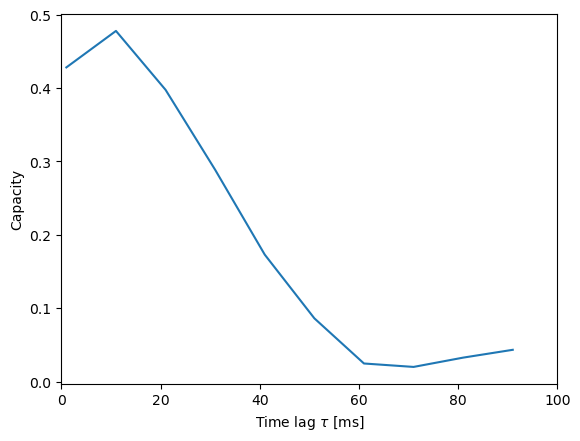

In [20]:
fig, ax = plt.subplots()
ax.plot(time_lags, memory_capacity)
ax.set_xlim([0., max_lag])
ax.set_xlabel(r'Time lag $\tau$ [ms]')
ax.set_ylabel(r'Capacity')
print("Total capacity: {0} ms".format(str(np.sum(memory_capacity)*step_lag)))